# YoloV3: Multi-task Face Detection and Facial Landmark Extraction


## Setup

In [1]:
#!git clone ..
#%cd yolov3

In [1]:
# Import packages
import cv2
import glob
import random
import torch
import numpy as  np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from pathlib import Path

from models import *
from utils.datasets import *
from utils.utils import *
from hyp import  hyp

from utils.torch_utils import select_device, time_synchronized
from utils.utils import non_max_suppression, xyxy2xywh
from utils.general import scale_coords, plot_one_box, plot_one_landmarks
from utils.inference_datasets import LoadImages, LoadWebcam

In [2]:
def get_model(net_type,  device, weights="", inference=False):
    assert net_type in ["mbv2_1", "mbv2_75"]
    
    if net_type.startswith("mbv2_1"):
        backbone = mobilenet_v2(pretrained=False, width_mult = 1.0)
    elif net_type.startswith("mbv2_75"):
        backbone = mobilenet_v2(pretrained=False, width_mult = 0.75)   
    elif net_type.startswith("darknet53"):
        backbone = DarkNet53()

    if 'light' in net_type:
        net = DarknetWithShh(backbone, hyp, light_head=True).to(device)
    else:
        net = DarknetWithShh(backbone, hyp).to(device)
    
    if weights:
        net.load_state_dict(torch.load(weights, map_location=device)['model'])
        
    if inference:
        net.eval()
        
    return net

## Training

In [4]:
def train(hyp, net_type, device, epochs = 250, batch_size = 16, weights = "" , backbone_weights = "",
          resume = False, img_size = [640]*3, optimizer_str = "adam", multi_scale_training = True,
          rect=False):

    accumulate = max(round(64 / batch_size), 1)  # accumulate n times before optimizer update (bs 64)

    imgsz_min, imgsz_max, imgsz_test = img_size  # img sizes (min, max, test)

    # Image Sizes
    gs = 64  # (pixels) grid size
    assert math.fmod(imgsz_min, gs) == 0, '--img-size %g must be a %g-multiple' % (imgsz_min, gs)
    multi_scale_training |= imgsz_min != imgsz_max  # multi if different (min, max)
    if multi_scale_training:
        if imgsz_min == imgsz_max:
            imgsz_min //= 1.5
            imgsz_max //= 0.667
        grid_min, grid_max = imgsz_min // gs, imgsz_max // gs
        imgsz_min, imgsz_max = int(grid_min * gs), int(grid_max * gs)
    img_size = imgsz_max  # initialize with max size

    # Configure run
    init_seeds()

    # Initialize model
    model = get_model(net_type,  device)
    print(model)
    print(model.info())
    
    # Optimizer
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in dict(model.named_parameters()).items():
        if '.bias' in k:
            pg2 += [v]  # biases
        elif 'Conv2d.weight' in k:
            pg1 += [v]  
        else:
            pg0 += [v]  

    if optimizer_str == "adam":
        hyp['lr0'] *= 0.1  # reduce lr (i.e. SGD=5E-3, Adam=5E-4)
        optimizer = optim.Adam(pg0, lr=hyp['lr0'])
    else:
        optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
        
    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    print('Optimizer groups: %g .bias, %g Conv2d.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    start_epoch = 0
    best_fitness = 0.0
    
    # Load pretrained weights if exists
    if weights.endswith('.pt'):  
        # Load checkpoints
        chkpt = torch.load(weights, map_location=device)

        # load model
        try:
            chkpt['model'] = {k: v for k, v in chkpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
            model.load_state_dict(chkpt['model'], strict=False)
        except KeyError as e:
            print("Weights could not be loaded!")
            pass
        
        if resume:
            # load optimizer
            if chkpt['optimizer'] is not None:
                optimizer.load_state_dict(chkpt['optimizer'])
                best_fitness = chkpt['best_fitness']

            # load results
            if chkpt.get('training_results') is not None:
                with open(results_file, 'w') as file:
                    file.write(chkpt['training_results'])  # write results.txt

            start_epoch = chkpt['epoch'] + 1
        del chkpt


    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.95 + 0.05  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = start_epoch - 1  

    # Load dataset
    dataset = LoadImagesAndLabels(train_path, img_size, batch_size,
                                  augment=True,
                                  hyp=hyp,  # augmentation hyperparameters
                                  rect=rect,  # rectangular training
                                  cache_images=False,
                                  single_cls=False,
                                  point_number=hyp['point_num'],
                                  flip_idx_pair=hyp['flip_idx_pair']
                                  )

    # Create dataloader
    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             num_workers=nw,
                                             shuffle=not rect,  # Shuffle=True unless rectangular training is used
                                             pin_memory=True,
                                             collate_fn=dataset.collate_fn)


    # Model parameters
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)


    # Model EMA
    ema = torch_utils.ModelEMA(model)

    # Start training
    nb = len(dataloader)  # number of batches
    n_burn = max(3 * nb, 500)  # burn-in iterations, max(3 epochs, 500 iterations)

    # torch.autograd.set_detect_anomaly(True)
    results = (0, 0, 0, 0, 0, 0, 0)  # 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
    best_total_loss = np.inf
    t0 = time.time()
    print('Image sizes %g - %g train, %g test' % (imgsz_min, imgsz_max, imgsz_test))
    print('Using %g dataloader workers' % nw)
    print('Starting training for %g epochs...' % epochs)
    
    if weights:
        wdir = "/".join((weights).split("/")[:-1])
    else:
        wdir = "../weights"
    total_losses = []
    for epoch in range(start_epoch, epochs):  
        model.train()

        mloss = torch.zeros(5).to(device)  # mean losses
        print(('\n' + '%10s' * 10) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls','land' , 'total', 'targets', 'img_size','lr'))
        pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
        for i, (imgs, targets, paths, _) in pbar: 
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device).float() / 255.0

            targets = targets.to(device)

            # Burn-in
            if ni <= n_burn:
                xi = [0, n_burn]  # x interp
                model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
                accumulate = max(1, np.interp(ni, xi, [1, 64 / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    x['weight_decay'] = np.interp(ni, xi, [0.0, hyp['weight_decay'] if j == 1 else 0.0])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [0.9, hyp['momentum']])

            # Multi-Scale
            if multi_scale_training:
                if ni / accumulate % 1 == 0:  #  adjust img_size (67% - 150%) every 1 batch
                    img_size = random.randrange(grid_min, grid_max + 1) * gs
                sf = img_size / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to 32-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            pred = model(imgs)

            # Loss computation
            loss, loss_items = compute_loss(pred, targets, model,point_number=hyp['point_num'])
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', loss_items)
                return results

            loss *= batch_size / 64  # scale loss
            
            # Backpropagation
            loss.backward()

            # Optimizer
            if ni % accumulate == 0:
                optimizer.step()
                optimizer.zero_grad()
                ema.update(model)

            # Print training results
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses  
            mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
    
            s = ('%10s' * 2 + '%10.3g' * 7 + "%10.5g") % ('%g/%g' % (epoch, epochs - 1), mem, *mloss, len(targets), img_size,scheduler.get_lr()[0])
            pbar.set_description(s)
        

        # Update scheduler
        scheduler.step()

        # Process epoch results
        ema.update_attr(model)
        final_epoch = epoch + 1 == epochs
    
        mloss_np = mloss.cpu().numpy()
        total_loss = mloss_np[-1]
        total_losses.append(total_loss)

        chkpt = {'epoch': epoch,
                 'best_fitness': best_fitness,
                 'model': ema.ema.module.state_dict() if hasattr(model, 'module') else ema.ema.state_dict(),
                 'optimizer': None if final_epoch else optimizer.state_dict()}

        # Save last, best and final checkpoints
        torch.save(chkpt, "{}/{}_last.pt".format(wdir, net_type))
        
        if total_loss < best_total_loss:
            torch.save(chkpt, "{}/{}_best.pt".format(wdir, net_type))
        
        
        if  final_epoch:
            torch.save(chkpt, "{}/{}_final.pt".format(wdir, net_type))

        del chkpt
        
    return total_losses

In [ ]:
net_type = "mbv2_1"
train_path = "../data/dataset/widerface/yololandmark_wider_train/"   # Path to training dataset

epochs = 250
batch_size = 4
weights = ""              # initial training weights
backbone_weights = ""
resume = False
img_size = [320, 640, 640]
optimizer_str = "adam"
multi_scale_training = True

In [ ]:
device = '0' if torch.cuda.is_available() else 'cpu'         
device = select_device(device)

total_losses = train(hyp, net_type, device, epochs, batch_size, weights , backbone_weights,
                     resume, img_size, optimizer_str, multi_scale_training)

In [ ]:
# Plot training total loss wrt. epochs
plt.plot(total_losses)
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Training Loss vs Epochs")

## Inference

In [7]:
def detect_faces(image, conf_thres=0.4, img_size=640):
    org_shape = image.shape
    img = letterbox(image, new_shape=img_size)[0]

    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to CxHXW
    img = np.ascontiguousarray(img)
    img = img.astype(np.float64)
    
    img = torch.from_numpy(img).to(device).float()

    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    t1 = time_synchronized()
    pred = model(img)[0]

    pred = non_max_suppression(pred,conf_thres, 0.35,
                               multi_label=False, classes=0, agnostic= False,land=True ,point_num=point_num)

    t2 = time_synchronized()
    # Postprocess detections
    dets = []
    for i, det in enumerate(pred):  # detections per image
        if det is not None:
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], org_shape).round()
                det[:, 5:5+point_num*2] = scale_coords(img.shape[2:], det[:, 5:5+point_num*2], org_shape).round()
                dets.append(det.detach().cpu().numpy())

    return np.array(dets)

Choose an image folder, a net type and a weight file for inference.

In [8]:
image_folder = "../data/inputs/images/"
net_type = "mbv2_1"
weights = f"../weights/{net_type}_last.pt"

In [9]:
device = '0' if torch.cuda.is_available() else 'cpu'
          
device = select_device(device)
model = get_model(net_type, device, weights, inference=True)
print(model.info())

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1660 Ti', total_memory=6144MB)

[32, 96, 160]


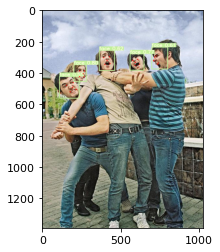

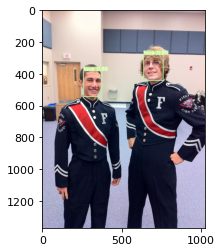

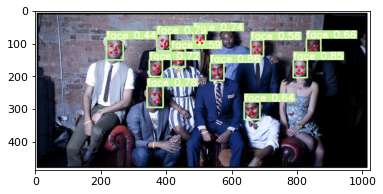

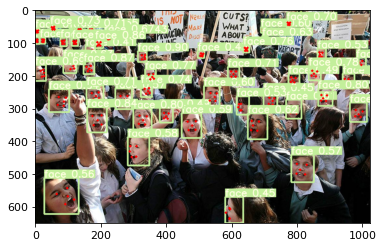

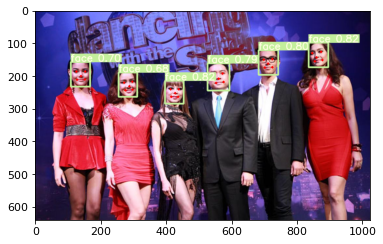

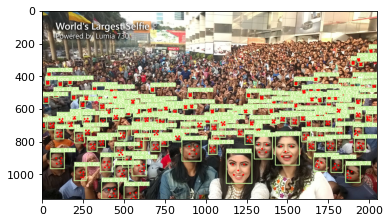

In [10]:
point_num = hyp['point_num']
names = ["face", "no_face"]
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
image_exts = ['jpg', 'png', 'jpeg']

file_paths = sorted(glob.glob(os.path.join(image_folder, '*.*'))) 
image_paths = [x for x in file_paths if x.split('.')[-1].lower() in image_exts]

for image_path in image_paths:
    image = cv2.imread(image_path)
    predictions = detect_faces(image, conf_thres=0.4, img_size=640)
    try:
        predictions = predictions[0]
    except:
        continue
    
    # Show results on images
    for (*bbox, conf), (*landmarks,cls) in zip(reversed(predictions[:, :5]), reversed(predictions[:, 5:])):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(bbox, image, label=label, color=colors[int(cls)], line_thickness=3)
        plot_one_landmarks(landmarks, image)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)

## Tests

### 1. Evaluation of Face Detection on Widerface Validation Dataset

In [11]:
from test import save_widerface_predictions
from evaluations import evaluate_widerface

In [12]:
val_image_root = f"/Users/Sefaburak/Downloads/WIDER_val/WIDER_val/images/{net_type}/"
val_results_root = "../outputs/widerface_results/"

save_widerface_predictions(model, val_image_root, val_results_root)

[1] 0_Parade_marchingband_1_1004.jpg is processed. detect: 18
[2] 0_Parade_marchingband_1_104.jpg is processed. detect: 49
[3] 0_Parade_marchingband_1_1045.jpg is processed. detect: 64
[4] 0_Parade_marchingband_1_139.jpg is processed. detect: 18
[5] 0_Parade_marchingband_1_147.jpg is processed. detect: 54
[6] 0_Parade_marchingband_1_149.jpg is processed. detect: 44
[7] 0_Parade_marchingband_1_156.jpg is processed. detect: 71
[8] 0_Parade_marchingband_1_172.jpg is processed. detect: 315
[9] 0_Parade_marchingband_1_188.jpg is processed. detect: 67
[10] 0_Parade_marchingband_1_20.jpg is processed. detect: 53
[11] 0_Parade_marchingband_1_227.jpg is processed. detect: 129
[12] 0_Parade_marchingband_1_234.jpg is processed. detect: 72
[13] 0_Parade_marchingband_1_267.jpg is processed. detect: 65
[14] 0_Parade_marchingband_1_309.jpg is processed. detect: 124
[15] 0_Parade_marchingband_1_311.jpg is processed. detect: 36
[16] 0_Parade_marchingband_1_329.jpg is processed. detect: 157
[17] 0_Parad

[140] 1_Handshaking_Handshaking_1_762.jpg is processed. detect: 5
[141] 1_Handshaking_Handshaking_1_766.jpg is processed. detect: 1
[142] 1_Handshaking_Handshaking_1_781.jpg is processed. detect: 2
[143] 1_Handshaking_Handshaking_1_801.jpg is processed. detect: 8
[144] 1_Handshaking_Handshaking_1_827.jpg is processed. detect: 4
[145] 1_Handshaking_Handshaking_1_94.jpg is processed. detect: 1
[146] 10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_240.jpg is processed. detect: 133
[147] 10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_368.jpg is processed. detect: 14
[148] 10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_447.jpg is processed. detect: 937
[149] 10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_499.jpg is processed. detect: 36
[150] 10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_524.jpg is processed. detect: 24
[151] 10_People_Marching_People_Marching_10

[238] 12_Group_Group_12_Group_Group_12_123.jpg is processed. detect: 8
[239] 12_Group_Group_12_Group_Group_12_144.jpg is processed. detect: 5
[240] 12_Group_Group_12_Group_Group_12_153.jpg is processed. detect: 17
[241] 12_Group_Group_12_Group_Group_12_165.jpg is processed. detect: 14
[242] 12_Group_Group_12_Group_Group_12_179.jpg is processed. detect: 18
[243] 12_Group_Group_12_Group_Group_12_182.jpg is processed. detect: 9
[244] 12_Group_Group_12_Group_Group_12_198.jpg is processed. detect: 5
[245] 12_Group_Group_12_Group_Group_12_218.jpg is processed. detect: 9
[246] 12_Group_Group_12_Group_Group_12_227.jpg is processed. detect: 34
[247] 12_Group_Group_12_Group_Group_12_247.jpg is processed. detect: 11
[248] 12_Group_Group_12_Group_Group_12_249.jpg is processed. detect: 44
[249] 12_Group_Group_12_Group_Group_12_253.jpg is processed. detect: 5
[250] 12_Group_Group_12_Group_Group_12_268.jpg is processed. detect: 35
[251] 12_Group_Group_12_Group_Group_12_28.jpg is processed. detect: 25

[344] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_340.jpg is processed. detect: 26
[345] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_353.jpg is processed. detect: 1
[346] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_364.jpg is processed. detect: 4
[347] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_403.jpg is processed. detect: 22
[348] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_412.jpg is processed. detect: 36
[349] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_418.jpg is processed. detect: 185
[350] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_442.jpg is processed. detect: 32
[351] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_458.jpg is processed. detect: 17
[352] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_461.jpg is processed. detect: 34
[353] 12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_50.jpg is proc

[440] 13_Interview_Interview_On_Location_13_521.jpg is processed. detect: 13
[441] 13_Interview_Interview_On_Location_13_537.jpg is processed. detect: 8
[442] 13_Interview_Interview_On_Location_13_539.jpg is processed. detect: 1
[443] 13_Interview_Interview_On_Location_13_542.jpg is processed. detect: 4
[444] 13_Interview_Interview_On_Location_13_554.jpg is processed. detect: 4
[445] 13_Interview_Interview_On_Location_13_559.jpg is processed. detect: 7
[446] 13_Interview_Interview_On_Location_13_56.jpg is processed. detect: 6
[447] 13_Interview_Interview_On_Location_13_569.jpg is processed. detect: 23
[448] 13_Interview_Interview_On_Location_13_605.jpg is processed. detect: 10
[449] 13_Interview_Interview_On_Location_13_610.jpg is processed. detect: 2
[450] 13_Interview_Interview_On_Location_13_636.jpg is processed. detect: 5
[451] 13_Interview_Interview_On_Location_13_728.jpg is processed. detect: 1
[452] 13_Interview_Interview_On_Location_13_736.jpg is processed. detect: 2
[453] 13_I

[557] 15_Stock_Market_Stock_Market_15_731.jpg is processed. detect: 1
[558] 15_Stock_Market_Stock_Market_15_751.jpg is processed. detect: 1
[559] 15_Stock_Market_Stock_Market_15_781.jpg is processed. detect: 4
[560] 15_Stock_Market_Stock_Market_15_846.jpg is processed. detect: 1
[561] 16_Award_Ceremony_Awards_Ceremony_16_116.jpg is processed. detect: 9
[562] 16_Award_Ceremony_Awards_Ceremony_16_124.jpg is processed. detect: 1
[563] 16_Award_Ceremony_Awards_Ceremony_16_134.jpg is processed. detect: 1
[564] 16_Award_Ceremony_Awards_Ceremony_16_135.jpg is processed. detect: 4
[565] 16_Award_Ceremony_Awards_Ceremony_16_141.jpg is processed. detect: 36
[566] 16_Award_Ceremony_Awards_Ceremony_16_143.jpg is processed. detect: 3
[567] 16_Award_Ceremony_Awards_Ceremony_16_195.jpg is processed. detect: 34
[568] 16_Award_Ceremony_Awards_Ceremony_16_226.jpg is processed. detect: 5
[569] 16_Award_Ceremony_Awards_Ceremony_16_231.jpg is processed. detect: 19
[570] 16_Award_Ceremony_Awards_Ceremony_16

[679] 18_Concerts_Concerts_18_602.jpg is processed. detect: 163
[680] 18_Concerts_Concerts_18_612.jpg is processed. detect: 3
[681] 18_Concerts_Concerts_18_655.jpg is processed. detect: 1
[682] 18_Concerts_Concerts_18_656.jpg is processed. detect: 3
[683] 18_Concerts_Concerts_18_657.jpg is processed. detect: 3
[684] 18_Concerts_Concerts_18_66.jpg is processed. detect: 98
[685] 18_Concerts_Concerts_18_665.jpg is processed. detect: 2
[686] 18_Concerts_Concerts_18_670.jpg is processed. detect: 13
[687] 18_Concerts_Concerts_18_693.jpg is processed. detect: 1
[688] 18_Concerts_Concerts_18_706.jpg is processed. detect: 3
[689] 18_Concerts_Concerts_18_784.jpg is processed. detect: 4
[690] 18_Concerts_Concerts_18_815.jpg is processed. detect: 18
[691] 18_Concerts_Concerts_18_828.jpg is processed. detect: 4
[692] 18_Concerts_Concerts_18_853.jpg is processed. detect: 16
[693] 18_Concerts_Concerts_18_855.jpg is processed. detect: 9
[694] 18_Concerts_Concerts_18_872.jpg is processed. detect: 34
[6

[793] 2_Demonstration_Demonstration_Or_Protest_2_813.jpg is processed. detect: 29
[794] 2_Demonstration_Demonstration_Or_Protest_2_816.jpg is processed. detect: 75
[795] 2_Demonstration_Demonstration_Or_Protest_2_895.jpg is processed. detect: 157
[796] 2_Demonstration_Demonstration_Or_Protest_2_914.jpg is processed. detect: 65
[797] 2_Demonstration_Demonstration_Or_Protest_2_915.jpg is processed. detect: 18
[798] 2_Demonstration_Demonstration_Or_Protest_2_924.jpg is processed. detect: 5
[799] 2_Demonstration_Demonstration_Or_Protest_2_942.jpg is processed. detect: 2
[800] 2_Demonstration_Demonstration_Or_Protest_2_98.jpg is processed. detect: 400
[801] 2_Demonstration_Demonstrators_2_100.jpg is processed. detect: 10
[802] 2_Demonstration_Demonstrators_2_12.jpg is processed. detect: 3
[803] 2_Demonstration_Demonstrators_2_162.jpg is processed. detect: 30
[804] 2_Demonstration_Demonstrators_2_163.jpg is processed. detect: 19
[805] 2_Demonstration_Demonstrators_2_170.jpg is processed. det

[907] 2_Demonstration_Political_Rally_2_896.jpg is processed. detect: 15
[908] 2_Demonstration_Political_Rally_2_90.jpg is processed. detect: 46
[909] 2_Demonstration_Political_Rally_2_940.jpg is processed. detect: 10
[910] 2_Demonstration_Political_Rally_2_960.jpg is processed. detect: 15
[911] 2_Demonstration_Political_Rally_2_985.jpg is processed. detect: 31
[912] 2_Demonstration_Protesters_2_1033.jpg is processed. detect: 9
[913] 2_Demonstration_Protesters_2_117.jpg is processed. detect: 5
[914] 2_Demonstration_Protesters_2_12.jpg is processed. detect: 44
[915] 2_Demonstration_Protesters_2_131.jpg is processed. detect: 225
[916] 2_Demonstration_Protesters_2_148.jpg is processed. detect: 14
[917] 2_Demonstration_Protesters_2_156.jpg is processed. detect: 17
[918] 2_Demonstration_Protesters_2_16.jpg is processed. detect: 6
[919] 2_Demonstration_Protesters_2_163.jpg is processed. detect: 115
[920] 2_Demonstration_Protesters_2_174.jpg is processed. detect: 16
[921] 2_Demonstration_Prot

[1029] 20_Family_Group_Family_Group_20_750.jpg is processed. detect: 2
[1030] 20_Family_Group_Family_Group_20_759.jpg is processed. detect: 16
[1031] 20_Family_Group_Family_Group_20_760.jpg is processed. detect: 3
[1032] 20_Family_Group_Family_Group_20_775.jpg is processed. detect: 7
[1033] 20_Family_Group_Family_Group_20_799.jpg is processed. detect: 14
[1034] 20_Family_Group_Family_Group_20_835.jpg is processed. detect: 11
[1035] 20_Family_Group_Family_Group_20_843.jpg is processed. detect: 6
[1036] 20_Family_Group_Family_Group_20_849.jpg is processed. detect: 5
[1037] 20_Family_Group_Family_Group_20_87.jpg is processed. detect: 6
[1038] 20_Family_Group_Family_Group_20_90.jpg is processed. detect: 7
[1039] 20_Family_Group_Family_Group_20_914.jpg is processed. detect: 34
[1040] 21_Festival_Festival_21_100.jpg is processed. detect: 25
[1041] 21_Festival_Festival_21_107.jpg is processed. detect: 46
[1042] 21_Festival_Festival_21_140.jpg is processed. detect: 24
[1043] 21_Festival_Festiv

[1158] 24_Soldier_Firing_Soldier_Firing_24_264.jpg is processed. detect: 11
[1159] 24_Soldier_Firing_Soldier_Firing_24_268.jpg is processed. detect: 2
[1160] 24_Soldier_Firing_Soldier_Firing_24_281.jpg is processed. detect: 3
[1161] 24_Soldier_Firing_Soldier_Firing_24_315.jpg is processed. detect: 13
[1162] 24_Soldier_Firing_Soldier_Firing_24_329.jpg is processed. detect: 1
[1163] 24_Soldier_Firing_Soldier_Firing_24_368.jpg is processed. detect: 2
[1164] 24_Soldier_Firing_Soldier_Firing_24_372.jpg is processed. detect: 1
[1165] 24_Soldier_Firing_Soldier_Firing_24_405.jpg is processed. detect: 9
[1166] 24_Soldier_Firing_Soldier_Firing_24_431.jpg is processed. detect: 5
[1167] 24_Soldier_Firing_Soldier_Firing_24_523.jpg is processed. detect: 2
[1168] 24_Soldier_Firing_Soldier_Firing_24_540.jpg is processed. detect: 8
[1169] 24_Soldier_Firing_Soldier_Firing_24_601.jpg is processed. detect: 30
[1170] 24_Soldier_Firing_Soldier_Firing_24_633.jpg is processed. detect: 32
[1171] 24_Soldier_Fir

[1265] 26_Soldier_Drilling_Soldiers_Drilling_26_886.jpg is processed. detect: 1
[1266] 26_Soldier_Drilling_Soldiers_Drilling_26_893.jpg is processed. detect: 4
[1267] 26_Soldier_Drilling_Soldiers_Drilling_26_9.jpg is processed. detect: 5
[1268] 26_Soldier_Drilling_Soldiers_Drilling_26_934.jpg is processed. detect: 12
[1269] 26_Soldier_Drilling_Soldiers_Drilling_26_942.jpg is processed. detect: 13
[1270] 26_Soldier_Drilling_Soldiers_Drilling_26_991.jpg is processed. detect: 18
[1271] 27_Spa_Spa_27_109.jpg is processed. detect: 5
[1272] 27_Spa_Spa_27_121.jpg is processed. detect: 3
[1273] 27_Spa_Spa_27_157.jpg is processed. detect: 4
[1274] 27_Spa_Spa_27_168.jpg is processed. detect: 3
[1275] 27_Spa_Spa_27_212.jpg is processed. detect: 2
[1276] 27_Spa_Spa_27_225.jpg is processed. detect: 1
[1277] 27_Spa_Spa_27_322.jpg is processed. detect: 1
[1278] 27_Spa_Spa_27_329.jpg is processed. detect: 1
[1279] 27_Spa_Spa_27_360.jpg is processed. detect: 1
[1280] 27_Spa_Spa_27_38.jpg is processed. 

[1382] 29_Students_Schoolkids_Students_Schoolkids_29_81.jpg is processed. detect: 9
[1383] 29_Students_Schoolkids_Students_Schoolkids_29_822.jpg is processed. detect: 6
[1384] 29_Students_Schoolkids_Students_Schoolkids_29_84.jpg is processed. detect: 6
[1385] 29_Students_Schoolkids_Students_Schoolkids_29_900.jpg is processed. detect: 2
[1386] 29_Students_Schoolkids_Students_Schoolkids_29_902.jpg is processed. detect: 10
[1387] 29_Students_Schoolkids_Students_Schoolkids_29_941.jpg is processed. detect: 3
[1388] 3_Riot_Riot_3_101.jpg is processed. detect: 31
[1389] 3_Riot_Riot_3_1037.jpg is processed. detect: 32
[1390] 3_Riot_Riot_3_106.jpg is processed. detect: 35
[1391] 3_Riot_Riot_3_123.jpg is processed. detect: 33
[1392] 3_Riot_Riot_3_137.jpg is processed. detect: 83
[1393] 3_Riot_Riot_3_166.jpg is processed. detect: 14
[1394] 3_Riot_Riot_3_184.jpg is processed. detect: 29
[1395] 3_Riot_Riot_3_186.jpg is processed. detect: 15
[1396] 3_Riot_Riot_3_199.jpg is processed. detect: 253
[13

[1510] 31_Waiter_Waitress_Waiter_Waitress_31_788.jpg is processed. detect: 11
[1511] 31_Waiter_Waitress_Waiter_Waitress_31_818.jpg is processed. detect: 10
[1512] 31_Waiter_Waitress_Waiter_Waitress_31_842.jpg is processed. detect: 3
[1513] 31_Waiter_Waitress_Waiter_Waitress_31_847.jpg is processed. detect: 1
[1514] 31_Waiter_Waitress_Waiter_Waitress_31_858.jpg is processed. detect: 2
[1515] 31_Waiter_Waitress_Waiter_Waitress_31_888.jpg is processed. detect: 2
[1516] 31_Waiter_Waitress_Waiter_Waitress_31_915.jpg is processed. detect: 6
[1517] 31_Waiter_Waitress_Waiter_Waitress_31_927.jpg is processed. detect: 1
[1518] 31_Waiter_Waitress_Waiter_Waitress_31_93.jpg is processed. detect: 2
[1519] 31_Waiter_Waitress_Waiter_Waitress_31_932.jpg is processed. detect: 2
[1520] 32_Worker_Laborer_Worker_Laborer_32_101.jpg is processed. detect: 3
[1521] 32_Worker_Laborer_Worker_Laborer_32_1038.jpg is processed. detect: 4
[1522] 32_Worker_Laborer_Worker_Laborer_32_1039.jpg is processed. detect: 3
[1

[1628] 35_Basketball_basketballgame_ball_35_290.jpg is processed. detect: 109
[1629] 35_Basketball_basketballgame_ball_35_309.jpg is processed. detect: 21
[1630] 35_Basketball_basketballgame_ball_35_341.jpg is processed. detect: 8
[1631] 35_Basketball_basketballgame_ball_35_375.jpg is processed. detect: 74
[1632] 35_Basketball_basketballgame_ball_35_389.jpg is processed. detect: 51
[1633] 35_Basketball_basketballgame_ball_35_391.jpg is processed. detect: 26
[1634] 35_Basketball_basketballgame_ball_35_393.jpg is processed. detect: 42
[1635] 35_Basketball_basketballgame_ball_35_412.jpg is processed. detect: 8
[1636] 35_Basketball_basketballgame_ball_35_423.jpg is processed. detect: 1
[1637] 35_Basketball_basketballgame_ball_35_429.jpg is processed. detect: 1
[1638] 35_Basketball_basketballgame_ball_35_446.jpg is processed. detect: 4
[1639] 35_Basketball_basketballgame_ball_35_460.jpg is processed. detect: 2
[1640] 35_Basketball_basketballgame_ball_35_478.jpg is processed. detect: 41
[164

[1741] 35_Basketball_playingbasketball_35_795.jpg is processed. detect: 81
[1742] 35_Basketball_playingbasketball_35_818.jpg is processed. detect: 2
[1743] 35_Basketball_playingbasketball_35_823.jpg is processed. detect: 1
[1744] 35_Basketball_playingbasketball_35_876.jpg is processed. detect: 270
[1745] 35_Basketball_playingbasketball_35_91.jpg is processed. detect: 3
[1746] 36_Football_americanfootball_ball_36_1021.jpg is processed. detect: 6
[1747] 36_Football_americanfootball_ball_36_111.jpg is processed. detect: 1
[1748] 36_Football_americanfootball_ball_36_114.jpg is processed. detect: 20
[1749] 36_Football_americanfootball_ball_36_126.jpg is processed. detect: 30
[1750] 36_Football_americanfootball_ball_36_132.jpg is processed. detect: 22
[1751] 36_Football_americanfootball_ball_36_16.jpg is processed. detect: 2
[1752] 36_Football_americanfootball_ball_36_162.jpg is processed. detect: 1
[1753] 36_Football_americanfootball_ball_36_234.jpg is processed. detect: 2
[1754] 36_Footbal

[1868] 38_Tennis_Tennis_38_592.jpg is processed. detect: 3
[1869] 38_Tennis_Tennis_38_604.jpg is processed. detect: 1
[1870] 38_Tennis_Tennis_38_666.jpg is processed. detect: 2
[1871] 38_Tennis_Tennis_38_683.jpg is processed. detect: 7
[1872] 38_Tennis_Tennis_38_692.jpg is processed. detect: 8
[1873] 38_Tennis_Tennis_38_717.jpg is processed. detect: 1
[1874] 38_Tennis_Tennis_38_754.jpg is processed. detect: 2
[1875] 38_Tennis_Tennis_38_758.jpg is processed. detect: 3
[1876] 38_Tennis_Tennis_38_81.jpg is processed. detect: 1
[1877] 38_Tennis_Tennis_38_94.jpg is processed. detect: 1
[1878] 39_Ice_Skating_iceskiing_39_1000.jpg is processed. detect: 2
[1879] 39_Ice_Skating_iceskiing_39_121.jpg is processed. detect: 3
[1880] 39_Ice_Skating_iceskiing_39_138.jpg is processed. detect: 26
[1881] 39_Ice_Skating_iceskiing_39_249.jpg is processed. detect: 1
[1882] 39_Ice_Skating_iceskiing_39_272.jpg is processed. detect: 6
[1883] 39_Ice_Skating_iceskiing_39_276.jpg is processed. detect: 5
[1884] 3

[1996] 4_Dancing_Dancing_4_922.jpg is processed. detect: 1
[1997] 4_Dancing_Dancing_4_960.jpg is processed. detect: 2
[1998] 4_Dancing_Dancing_4_97.jpg is processed. detect: 13
[1999] 4_Dancing_Dancing_4_983.jpg is processed. detect: 2
[2000] 40_Gymnastics_Gymnastics_40_1022.jpg is processed. detect: 1
[2001] 40_Gymnastics_Gymnastics_40_1035.jpg is processed. detect: 1
[2002] 40_Gymnastics_Gymnastics_40_1043.jpg is processed. detect: 12
[2003] 40_Gymnastics_Gymnastics_40_1044.jpg is processed. detect: 1
[2004] 40_Gymnastics_Gymnastics_40_108.jpg is processed. detect: 3
[2005] 40_Gymnastics_Gymnastics_40_115.jpg is processed. detect: 3
[2006] 40_Gymnastics_Gymnastics_40_138.jpg is processed. detect: 2
[2007] 40_Gymnastics_Gymnastics_40_156.jpg is processed. detect: 3
[2008] 40_Gymnastics_Gymnastics_40_161.jpg is processed. detect: 8
[2009] 40_Gymnastics_Gymnastics_40_171.jpg is processed. detect: 104
[2010] 40_Gymnastics_Gymnastics_40_175.jpg is processed. detect: 11
[2011] 40_Gymnastic

[2123] 41_Swimming_Swimming_41_238.jpg is processed. detect: 5
[2124] 41_Swimming_Swimming_41_240.jpg is processed. detect: 2
[2125] 41_Swimming_Swimming_41_243.jpg is processed. detect: 31
[2126] 41_Swimming_Swimming_41_26.jpg is processed. detect: 0
[2127] 41_Swimming_Swimming_41_271.jpg is processed. detect: 8
[2128] 41_Swimming_Swimming_41_275.jpg is processed. detect: 3
[2129] 41_Swimming_Swimming_41_283.jpg is processed. detect: 1
[2130] 41_Swimming_Swimming_41_379.jpg is processed. detect: 3
[2131] 41_Swimming_Swimming_41_380.jpg is processed. detect: 2
[2132] 41_Swimming_Swimming_41_412.jpg is processed. detect: 2
[2133] 41_Swimming_Swimming_41_466.jpg is processed. detect: 3
[2134] 41_Swimming_Swimming_41_472.jpg is processed. detect: 1
[2135] 41_Swimming_Swimming_41_52.jpg is processed. detect: 2
[2136] 41_Swimming_Swimming_41_521.jpg is processed. detect: 6
[2137] 41_Swimming_Swimming_41_535.jpg is processed. detect: 1
[2138] 41_Swimming_Swimming_41_580.jpg is processed. det

[2256] 44_Aerobics_Aerobics_44_794.jpg is processed. detect: 2
[2257] 44_Aerobics_Aerobics_44_809.jpg is processed. detect: 5
[2258] 44_Aerobics_Aerobics_44_852.jpg is processed. detect: 49
[2259] 44_Aerobics_Aerobics_44_916.jpg is processed. detect: 26
[2260] 44_Aerobics_Aerobics_44_919.jpg is processed. detect: 10
[2261] 44_Aerobics_Aerobics_44_936.jpg is processed. detect: 10
[2262] 44_Aerobics_Aerobics_44_937.jpg is processed. detect: 2
[2263] 44_Aerobics_Aerobics_44_96.jpg is processed. detect: 14
[2264] 45_Balloonist_Balloonist_45_1028.jpg is processed. detect: 56
[2265] 45_Balloonist_Balloonist_45_107.jpg is processed. detect: 18
[2266] 45_Balloonist_Balloonist_45_118.jpg is processed. detect: 23
[2267] 45_Balloonist_Balloonist_45_134.jpg is processed. detect: 2
[2268] 45_Balloonist_Balloonist_45_142.jpg is processed. detect: 2
[2269] 45_Balloonist_Balloonist_45_149.jpg is processed. detect: 1
[2270] 45_Balloonist_Balloonist_45_160.jpg is processed. detect: 1
[2271] 45_Balloonis

[2371] 47_Matador_Bullfighter_Matador_Bullfighter_47_468.jpg is processed. detect: 4
[2372] 47_Matador_Bullfighter_Matador_Bullfighter_47_566.jpg is processed. detect: 3
[2373] 47_Matador_Bullfighter_Matador_Bullfighter_47_567.jpg is processed. detect: 32
[2374] 47_Matador_Bullfighter_Matador_Bullfighter_47_575.jpg is processed. detect: 2
[2375] 47_Matador_Bullfighter_Matador_Bullfighter_47_583.jpg is processed. detect: 12
[2376] 47_Matador_Bullfighter_Matador_Bullfighter_47_588.jpg is processed. detect: 6
[2377] 47_Matador_Bullfighter_Matador_Bullfighter_47_610.jpg is processed. detect: 4
[2378] 47_Matador_Bullfighter_Matador_Bullfighter_47_617.jpg is processed. detect: 2
[2379] 47_Matador_Bullfighter_Matador_Bullfighter_47_631.jpg is processed. detect: 27
[2380] 47_Matador_Bullfighter_Matador_Bullfighter_47_636.jpg is processed. detect: 3
[2381] 47_Matador_Bullfighter_Matador_Bullfighter_47_703.jpg is processed. detect: 13
[2382] 47_Matador_Bullfighter_Matador_Bullfighter_47_715.jpg 

[2485] 5_Car_Accident_Car_Crash_5_451.jpg is processed. detect: 5
[2486] 5_Car_Accident_Car_Crash_5_457.jpg is processed. detect: 5
[2487] 5_Car_Accident_Car_Crash_5_475.jpg is processed. detect: 3
[2488] 5_Car_Accident_Car_Crash_5_492.jpg is processed. detect: 2
[2489] 5_Car_Accident_Car_Crash_5_51.jpg is processed. detect: 18
[2490] 5_Car_Accident_Car_Crash_5_544.jpg is processed. detect: 5
[2491] 5_Car_Accident_Car_Crash_5_574.jpg is processed. detect: 29
[2492] 5_Car_Accident_Car_Crash_5_610.jpg is processed. detect: 2
[2493] 5_Car_Accident_Car_Crash_5_644.jpg is processed. detect: 3
[2494] 5_Car_Accident_Car_Crash_5_773.jpg is processed. detect: 12
[2495] 5_Car_Accident_Car_Crash_5_866.jpg is processed. detect: 18
[2496] 5_Car_Accident_Car_Crash_5_868.jpg is processed. detect: 4
[2497] 5_Car_Accident_Car_Crash_5_94.jpg is processed. detect: 12
[2498] 50_Celebration_Or_Party_birthdayparty_50_134.jpg is processed. detect: 48
[2499] 50_Celebration_Or_Party_birthdayparty_50_144.jpg is

[2604] 51_Dresses_wearingdress_51_739.jpg is processed. detect: 30
[2605] 51_Dresses_wearingdress_51_741.jpg is processed. detect: 1
[2606] 51_Dresses_wearingdress_51_748.jpg is processed. detect: 4
[2607] 51_Dresses_wearingdress_51_763.jpg is processed. detect: 4
[2608] 51_Dresses_wearingdress_51_77.jpg is processed. detect: 10
[2609] 51_Dresses_wearingdress_51_789.jpg is processed. detect: 2
[2610] 51_Dresses_wearingdress_51_815.jpg is processed. detect: 2
[2611] 51_Dresses_wearingdress_51_830.jpg is processed. detect: 13
[2612] 51_Dresses_wearingdress_51_837.jpg is processed. detect: 3
[2613] 51_Dresses_wearingdress_51_869.jpg is processed. detect: 3
[2614] 51_Dresses_wearingdress_51_874.jpg is processed. detect: 1
[2615] 51_Dresses_wearingdress_51_883.jpg is processed. detect: 6
[2616] 51_Dresses_wearingdress_51_904.jpg is processed. detect: 5
[2617] 51_Dresses_wearingdress_51_914.jpg is processed. detect: 10
[2618] 51_Dresses_wearingdress_51_94.jpg is processed. detect: 2
[2619] 5

[2718] 53_Raid_policeraid_53_858.jpg is processed. detect: 19
[2719] 53_Raid_policeraid_53_860.jpg is processed. detect: 1
[2720] 53_Raid_policeraid_53_92.jpg is processed. detect: 14
[2721] 53_Raid_policeraid_53_928.jpg is processed. detect: 6
[2722] 53_Raid_policeraid_53_951.jpg is processed. detect: 1
[2723] 54_Rescue_firemanrescue_54_103.jpg is processed. detect: 2
[2724] 54_Rescue_firemanrescue_54_153.jpg is processed. detect: 1
[2725] 54_Rescue_firemanrescue_54_327.jpg is processed. detect: 1
[2726] 54_Rescue_firemanrescue_54_420.jpg is processed. detect: 2
[2727] 54_Rescue_firemanrescue_54_458.jpg is processed. detect: 8
[2728] 54_Rescue_firemanrescue_54_478.jpg is processed. detect: 5
[2729] 54_Rescue_firemanrescue_54_617.jpg is processed. detect: 9
[2730] 54_Rescue_firemanrescue_54_660.jpg is processed. detect: 5
[2731] 54_Rescue_firemanrescue_54_724.jpg is processed. detect: 6
[2732] 54_Rescue_firemanrescue_54_789.jpg is processed. detect: 2
[2733] 54_Rescue_firemanrescue_54_

[2836] 56_Voter_peoplevoting_56_103.jpg is processed. detect: 2
[2837] 56_Voter_peoplevoting_56_1046.jpg is processed. detect: 2
[2838] 56_Voter_peoplevoting_56_110.jpg is processed. detect: 15
[2839] 56_Voter_peoplevoting_56_118.jpg is processed. detect: 20
[2840] 56_Voter_peoplevoting_56_122.jpg is processed. detect: 107
[2841] 56_Voter_peoplevoting_56_13.jpg is processed. detect: 3
[2842] 56_Voter_peoplevoting_56_140.jpg is processed. detect: 2
[2843] 56_Voter_peoplevoting_56_21.jpg is processed. detect: 26
[2844] 56_Voter_peoplevoting_56_228.jpg is processed. detect: 18
[2845] 56_Voter_peoplevoting_56_260.jpg is processed. detect: 37
[2846] 56_Voter_peoplevoting_56_268.jpg is processed. detect: 132
[2847] 56_Voter_peoplevoting_56_305.jpg is processed. detect: 3
[2848] 56_Voter_peoplevoting_56_323.jpg is processed. detect: 1
[2849] 56_Voter_peoplevoting_56_339.jpg is processed. detect: 11
[2850] 56_Voter_peoplevoting_56_344.jpg is processed. detect: 40
[2851] 56_Voter_peoplevoting_5

[2965] 58_Hockey_icehockey_puck_58_880.jpg is processed. detect: 10
[2966] 58_Hockey_icehockey_puck_58_895.jpg is processed. detect: 16
[2967] 58_Hockey_icehockey_puck_58_926.jpg is processed. detect: 33
[2968] 58_Hockey_icehockey_puck_58_94.jpg is processed. detect: 25
[2969] 58_Hockey_icehockey_puck_58_940.jpg is processed. detect: 16
[2970] 59_peopledrivingcar_peopledrivingcar_59_1014.jpg is processed. detect: 7
[2971] 59_peopledrivingcar_peopledrivingcar_59_1019.jpg is processed. detect: 9
[2972] 59_peopledrivingcar_peopledrivingcar_59_1020.jpg is processed. detect: 2
[2973] 59_peopledrivingcar_peopledrivingcar_59_1038.jpg is processed. detect: 1
[2974] 59_peopledrivingcar_peopledrivingcar_59_117.jpg is processed. detect: 2
[2975] 59_peopledrivingcar_peopledrivingcar_59_172.jpg is processed. detect: 11
[2976] 59_peopledrivingcar_peopledrivingcar_59_200.jpg is processed. detect: 2
[2977] 59_peopledrivingcar_peopledrivingcar_59_201.jpg is processed. detect: 3
[2978] 59_peopledrivingc

[3085] 7_Cheering_Cheering_7_293.jpg is processed. detect: 1
[3086] 7_Cheering_Cheering_7_313.jpg is processed. detect: 34
[3087] 7_Cheering_Cheering_7_334.jpg is processed. detect: 21
[3088] 7_Cheering_Cheering_7_345.jpg is processed. detect: 81
[3089] 7_Cheering_Cheering_7_373.jpg is processed. detect: 9
[3090] 7_Cheering_Cheering_7_386.jpg is processed. detect: 88
[3091] 7_Cheering_Cheering_7_391.jpg is processed. detect: 58
[3092] 7_Cheering_Cheering_7_404.jpg is processed. detect: 18
[3093] 7_Cheering_Cheering_7_408.jpg is processed. detect: 11
[3094] 7_Cheering_Cheering_7_413.jpg is processed. detect: 48
[3095] 7_Cheering_Cheering_7_426.jpg is processed. detect: 36
[3096] 7_Cheering_Cheering_7_427.jpg is processed. detect: 7
[3097] 7_Cheering_Cheering_7_462.jpg is processed. detect: 43
[3098] 7_Cheering_Cheering_7_469.jpg is processed. detect: 24
[3099] 7_Cheering_Cheering_7_473.jpg is processed. detect: 2
[3100] 7_Cheering_Cheering_7_500.jpg is processed. detect: 1
[3101] 7_Chee

[3202] 9_Press_Conference_Press_Conference_9_613.jpg is processed. detect: 1
[3203] 9_Press_Conference_Press_Conference_9_615.jpg is processed. detect: 1
[3204] 9_Press_Conference_Press_Conference_9_632.jpg is processed. detect: 1
[3205] 9_Press_Conference_Press_Conference_9_636.jpg is processed. detect: 1
[3206] 9_Press_Conference_Press_Conference_9_648.jpg is processed. detect: 6
[3207] 9_Press_Conference_Press_Conference_9_655.jpg is processed. detect: 51
[3208] 9_Press_Conference_Press_Conference_9_658.jpg is processed. detect: 1
[3209] 9_Press_Conference_Press_Conference_9_66.jpg is processed. detect: 11
[3210] 9_Press_Conference_Press_Conference_9_693.jpg is processed. detect: 7
[3211] 9_Press_Conference_Press_Conference_9_710.jpg is processed. detect: 2
[3212] 9_Press_Conference_Press_Conference_9_74.jpg is processed. detect: 3
[3213] 9_Press_Conference_Press_Conference_9_748.jpg is processed. detect: 2
[3214] 9_Press_Conference_Press_Conference_9_757.jpg is processed. detect: 1

In [21]:
pred_path = "../outputs/widerface_results/mbv2_1/"
gt_path = "./evaluations/widerface/ground_truth/"

evaluate_widerface(pred_path, gt_path)

Processing easy: 100%|█████████████████████████████████████████████████████████████████| 61/61 [00:18<00:00,  3.24it/s]
D:\Users\Sefaburak\Desktop\Courses\Cogs\MSc-1st(2020-2021)\Fall\Mmi727\project\project_files\yolov3-facial-landmark-detection\src\evaluations\widerface\evaluate_widerface.py:204: RuntimeWarning: invalid value encountered in double_scalars
  _pr_curve[i, 0] = pr_curve[i, 1] / pr_curve[i, 0]
Processing hard: 100%|█████████████████████████████████████████████████████████████████| 61/61 [00:17<00:00,  3.54it/s]

==================== Results ====================
Easy   Val AP: 0.861193909637135
Medium Val AP: 0.849145017309316
Hard   Val AP: 0.6649306161041503


### 2. Evaluation of Facial Landmarks Extraction on Widerface Validation Dataset

In [16]:
model.info()

Model Summary: 210 layers, 1.54421e+06 parameters, 1.54421e+06 gradients
